## Time Series Analysis of US Air Quality by State and County

### Part I: Sample one State and County, initial EDA, cleaning and initial time-series model

Author: Gem Ruby </br>
Date: April 2023

In [ ]:
import numpy as np
import pandas as pd
import requests
import warnings
warnings.filterwarnings("ignore")

# plotting
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import matplotlib.pyplot as plt
import seaborn as sns

# stats
from statsmodels.api import tsa # time series analysis
import statsmodels.api as sm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
aqi = pd.read_csv('/content/drive/MyDrive/2022 - BrainStation/AirQuality_Capstone/aqi_daily_1980_to_2021.csv')

In [ ]:
aqi['Date'] = pd.to_datetime(aqi['Date'])

In [ ]:
#review the data initial data
aqi

State Name       Date  AQI Category Defining Parameter   Latitude  \
0           Alabama 2021-01-01   30     Good              Ozone  34.289001   
1           Alabama 2021-01-02   27     Good              Ozone  34.289001   
2           Alabama 2021-01-03   34     Good              Ozone  34.289001   
3           Alabama 2021-01-04   36     Good              Ozone  34.289001   
4           Alabama 2021-01-05   31     Good              Ozone  34.289001   
...             ...        ...  ...      ...                ...        ...   
10158522    Wyoming 2020-12-27   32     Good              Ozone  43.845390   
10158523    Wyoming 2020-12-28   30     Good              Ozone  43.845390   
10158524    Wyoming 2020-12-29   33     Good              Ozone  43.845390   
10158525    Wyoming 2020-12-30   33     Good              Ozone  43.845390   
10158526    Wyoming 2020-12-31   34     Good              Ozone  43.845390   

           Longitude County Name  
0         -85.970065      DeKalb  
1         -85.970065      DeKalb  
2         -85.970065      DeKalb  
3         -85.970065      DeKalb  
4         -85.970065      DeKalb  
...              ...         ...  
10158522 -104.205120      Weston  
10158523 -104.205120      Weston  
10158524 -104.205120      Weston  
10158525 -104.205120      Weston  
10158526 -104.205120      Weston  

[10158527 rows x 8 columns]

In [ ]:
#Data frame number of columns and entries
aqi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10158527 entries, 0 to 10158526
Data columns (total 8 columns):
 #   Column              Dtype         
---  ------              -----         
 0   State Name          object        
 1   Date                datetime64[ns]
 2   AQI                 int64         
 3   Category            object        
 4   Defining Parameter  object        
 5   Latitude            float64       
 6   Longitude           float64       
 7   County Name         object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 620.0+ MB


In [ ]:
#Understand the category grouping
aqi_category = aqi.groupby(['Category']).agg(
             Minimum_AQI = ('AQI','min'),
             Maximum_AQI = ('AQI','max')
)

#reset index
aqi_category = aqi_category.reset_index().sort_values('Minimum_AQI')

#view the data
aqi_category

Category  Minimum_AQI  Maximum_AQI
0                            Good            0           50
2                        Moderate           51          100
4  Unhealthy for Sensitive Groups          101          150
3                       Unhealthy          151          200
5                  Very Unhealthy          201          300
1                       Hazardous          301        20646

In [ ]:
#Understand the parameter grouping
aqi_parameters = aqi.groupby(['Defining Parameter']).agg(
             Count = ('AQI','count'),
             Maximum_AQI = ('AQI','max')
)

#reset index
aqi_parameters = aqi_parameters.sort_values('Maximum_AQI')

#view the data
aqi_parameters

Count  Maximum_AQI
Defining Parameter                      
Ozone               5183536          396
NO2                  493484          410
CO                   367918          453
SO2                 1372969          532
PM2.5               2157572          669
PM10                 583048        20646

In [ ]:
print(aqi['Date'].min())
print(aqi['Date'].max())

1980-01-01 00:00:00
2021-05-06 00:00:00


In [ ]:
#Create new df to understand existing number of AQI values in each state, county grouping
aqi_counts = aqi.groupby(['State Name','County Name']).agg(
             Count = ('AQI','count'),
             Minimum_Date = ('Date','min'),
             Maximum_Date = ('Date','max'),
             Longitude = ('Longitude','min'),
             Latitude = ('Latitude','min')

)

#reset index
aqi_counts_df = aqi_counts.reset_index()

#view the data
aqi_counts_df.head()


State Name County Name  Count Minimum_Date Maximum_Date  Longitude  \
0    Alabama     Baldwin   5703   2000-01-16   2020-12-20 -87.880258   
1    Alabama        Clay   6083   1991-03-26   2020-12-29 -85.803608   
2    Alabama      DeKalb  10857   1990-01-01   2021-02-28 -85.970065   
3    Alabama      Elmore   7401   1990-03-01   2020-10-23 -86.255193   
4    Alabama    Escambia   1513   1990-01-05   2007-12-29 -87.543500   

    Latitude  
0  30.497478  
1  33.284928  
2  34.289001  
3  32.535680  
4  31.092100

In [ ]:
#calculate the difference
aqi_counts_df['DateDiff'] = (aqi_counts_df['Maximum_Date'] - aqi_counts_df['Minimum_Date']).dt.days

#calulate the % of difference
aqi_counts_df['pct_of_data'] = round(aqi_counts_df['Count'] / aqi_counts_df['DateDiff'] *100,2)

#at 75% data points, add as 1, otherwise 0 using np.where
aqi_counts_df['greater than 75%'] = np.where(aqi_counts_df['pct_of_data'] > 75, 1, 0)

In [ ]:
aqi_counts_df.mean()

Count                9693.250954
Longitude             -92.826670
Latitude               38.616633
DateDiff            12301.051527
pct_of_data            77.562567
greater than 75%        0.623092
dtype: float64

In [ ]:
#calculate state and county combination in the data set 
all_state_county = aqi_counts_df[['State Name','County Name']]

all_state_county['State_County'] = aqi_counts_df['State Name']+'_'+aqi_counts_df['County Name']

all_state_county['Data'] = aqi_counts_df['greater than 75%']

all_state_county['Longitude'] = aqi_counts_df['Longitude']

all_state_county['Latitude'] = aqi_counts_df['Latitude']

all_state_county

State Name County Name        State_County  Data   Longitude   Latitude
0       Alabama     Baldwin     Alabama_Baldwin     0  -87.880258  30.497478
1       Alabama        Clay        Alabama_Clay     0  -85.803608  33.284928
2       Alabama      DeKalb      Alabama_DeKalb     1  -85.970065  34.289001
3       Alabama      Elmore      Alabama_Elmore     0  -86.255193  32.535680
4       Alabama    Escambia    Alabama_Escambia     0  -87.543500  31.092100
...         ...         ...                 ...   ...         ...        ...
1043    Wyoming    Sublette    Wyoming_Sublette     1 -109.788000  42.928800
1044    Wyoming  Sweetwater  Wyoming_Sweetwater     0 -108.734440  41.763060
1045    Wyoming       Teton       Wyoming_Teton     1 -110.400996  44.565217
1046    Wyoming       Uinta       Wyoming_Uinta     0 -110.702153  41.408699
1047    Wyoming      Weston      Wyoming_Weston     1 -104.205120  43.845390

[1048 rows x 6 columns]

In [ ]:
#extract and visualize in tableau
all_state_county.to_csv('county.csv',index=False)

In [ ]:
counties_per_state = aqi_counts_df[aqi_counts_df['greater than 75%'] == 1].groupby('State Name')['County Name'].count()

counties_per_state = counties_per_state.to_frame('County 75%')

In [ ]:
counties_per_state.sum()

County 75%    653
dtype: int64

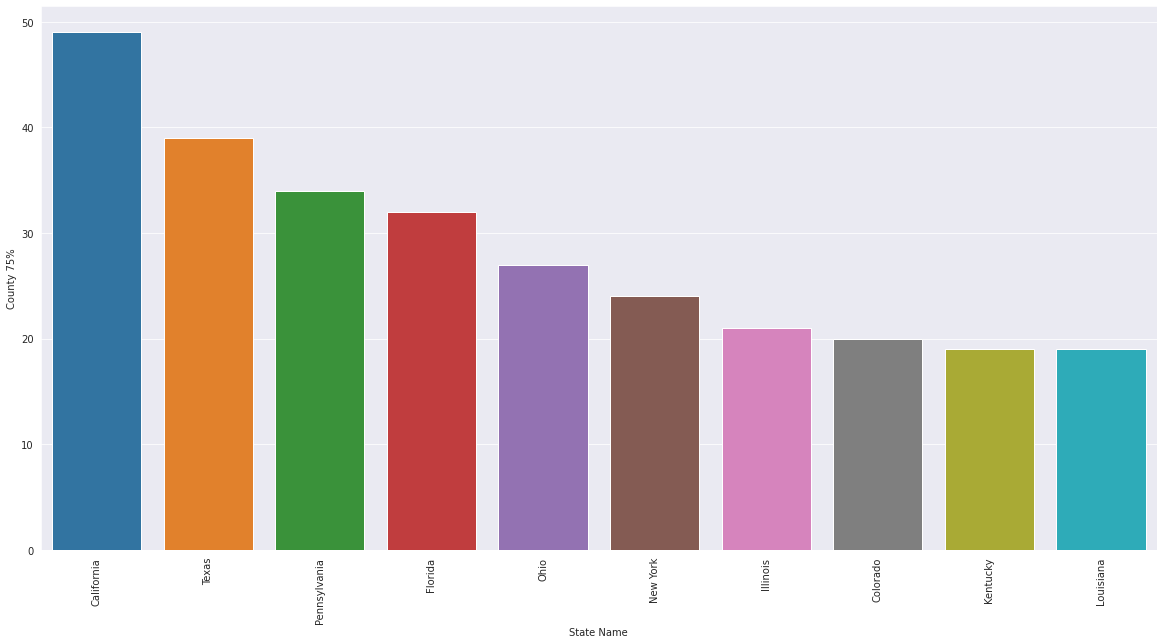

In [ ]:
counties_per_state_sorted = counties_per_state.sort_values('County 75%', ascending=False).head(10)

plt.figure(figsize=(20,10))
sns.set_style('darkgrid')
sns.barplot(data = counties_per_state_sorted, x = counties_per_state_sorted.index, y='County 75%')
plt.savefig('/content/drive/MyDrive/2022 - BrainStation/AirQuality_Capstone/plots/Counties_with_75Data.png')
plt.xticks(rotation=90)
plt.show()

In [ ]:
counties_per_state.sum()

County 75%    653
dtype: int64

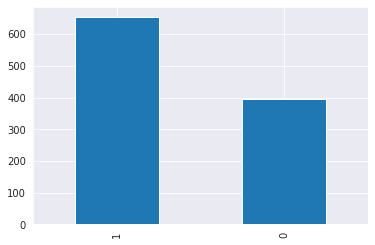

In [ ]:
plt.figure()
aqi_counts_df['greater than 75%'].value_counts().plot(kind='bar')
plt.show()

In [ ]:
import plotly.express as px

fig = px.scatter(aqi_counts_df, x=aqi_counts_df.index, y="pct_of_data", color="State Name", hover_data=['County Name'])
fig.add_shape(type='line',
              x0=aqi_counts_df.index.min(), y0=75,
              x1=aqi_counts_df.index.max(), y1=75,
              line=dict(color='red', width=1))
fig.show()

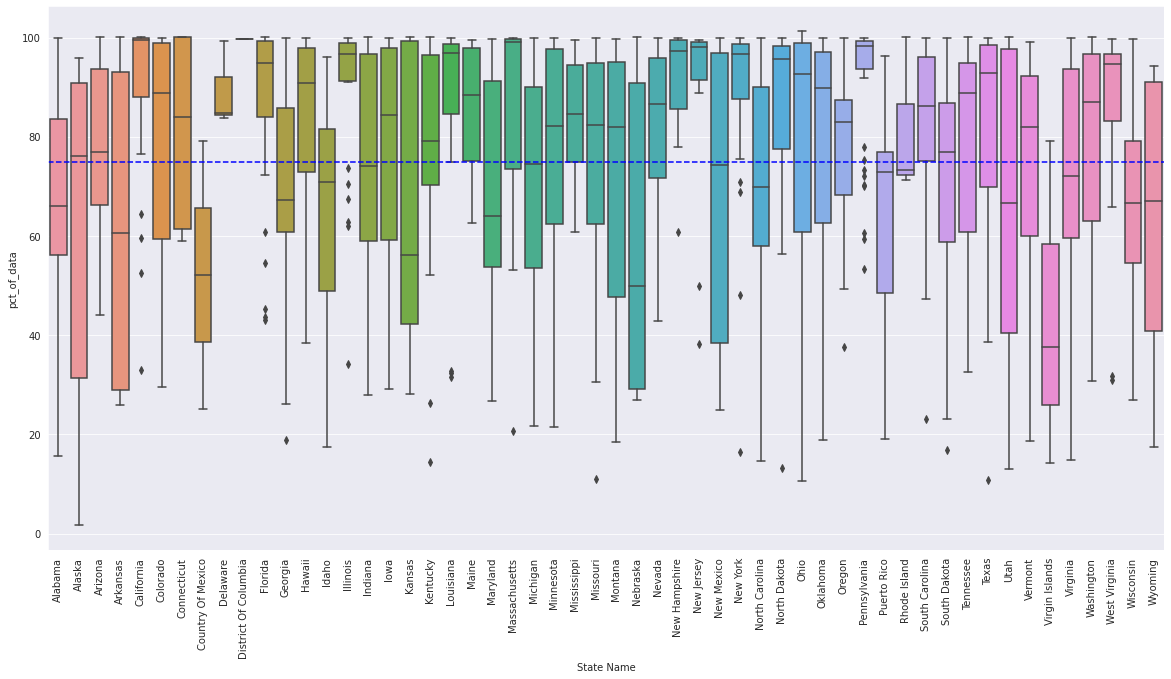

In [ ]:
plt.figure(figsize=(20,10))
sns.set_style('darkgrid')
sns.boxplot(data = aqi_counts_df, x = "State Name", y="pct_of_data")
plt.axhline(y=75, color='Blue', linestyle = '--')
plt.xticks(rotation=90)
plt.show()

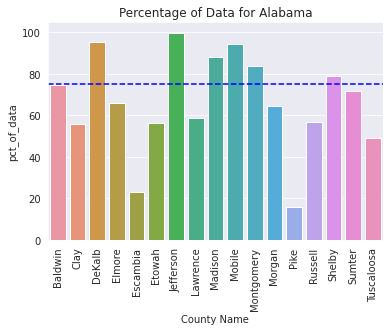

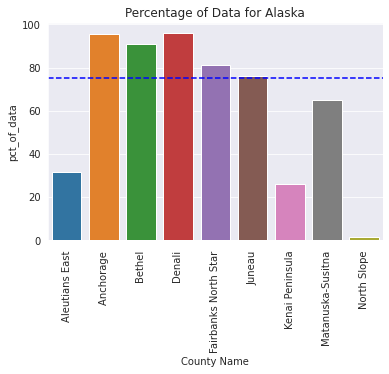

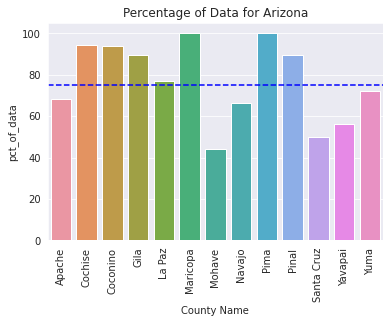

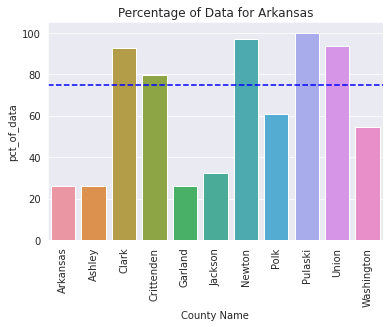

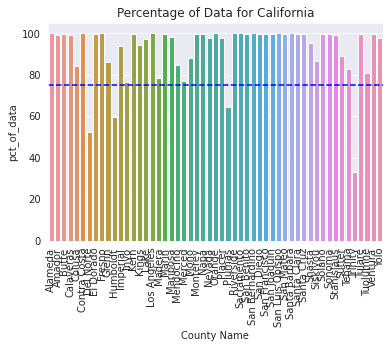

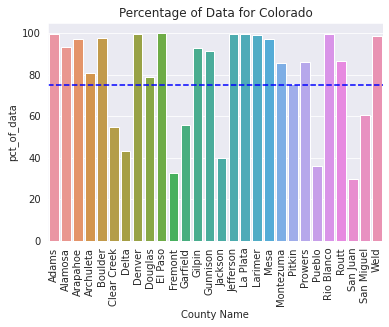

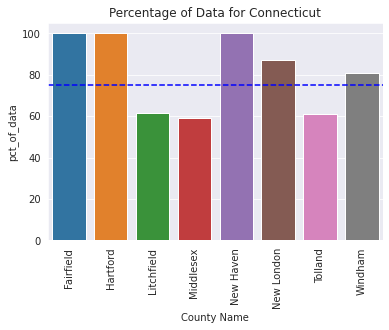

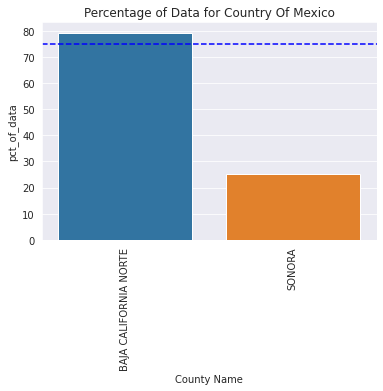

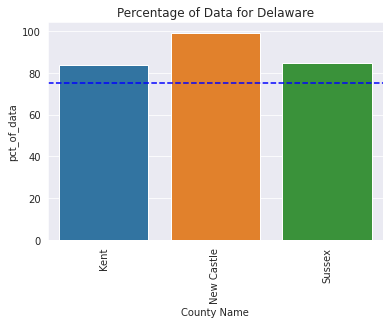

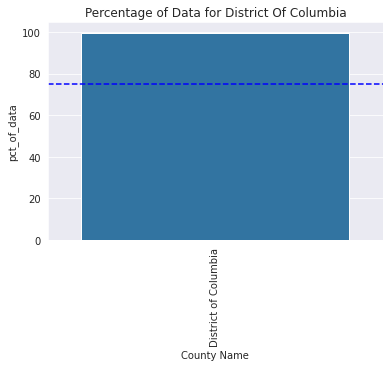

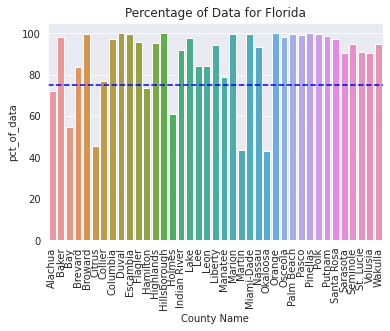

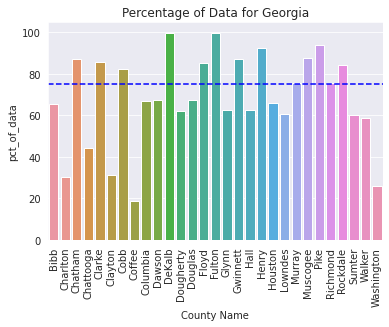

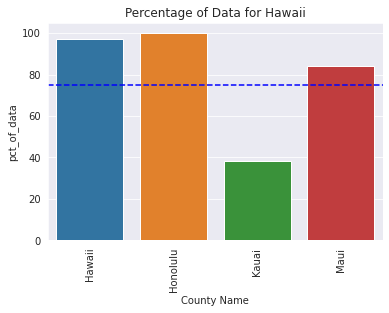

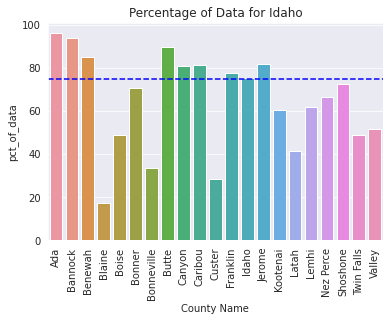

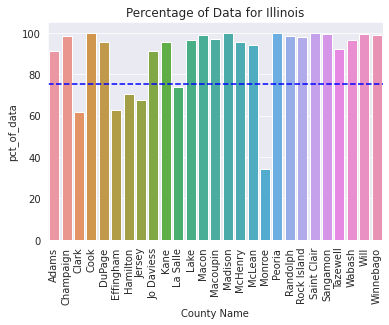

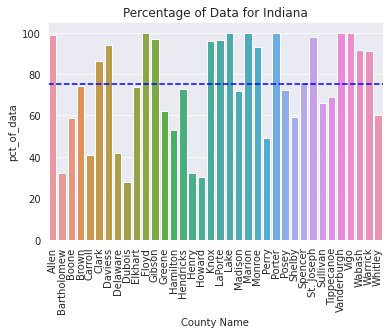

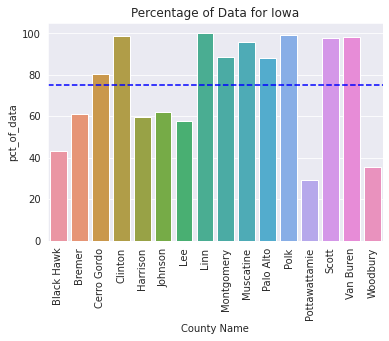

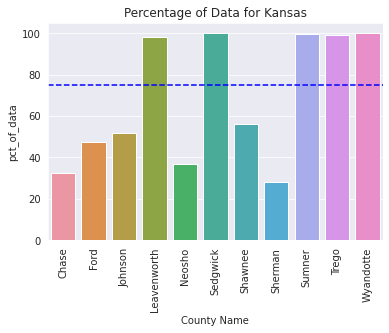

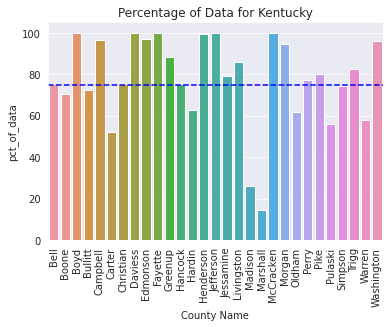

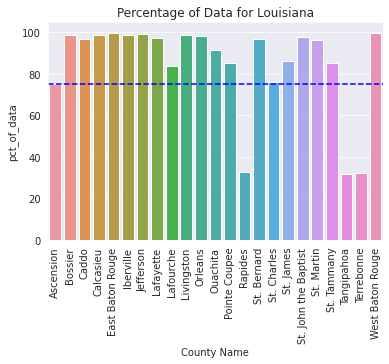

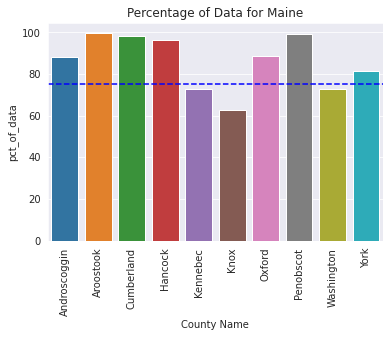

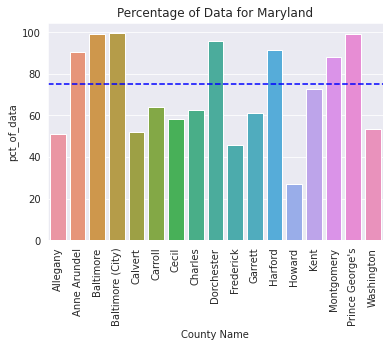

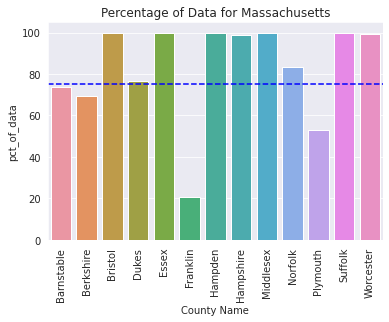

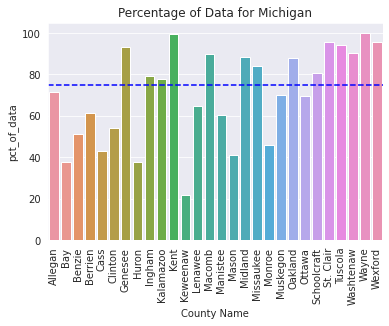

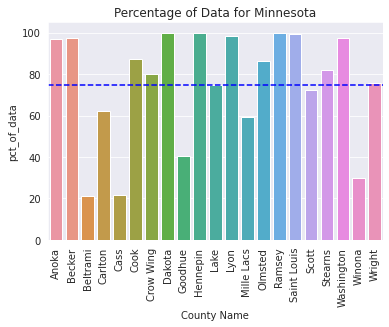

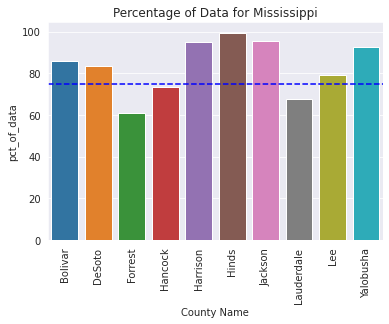

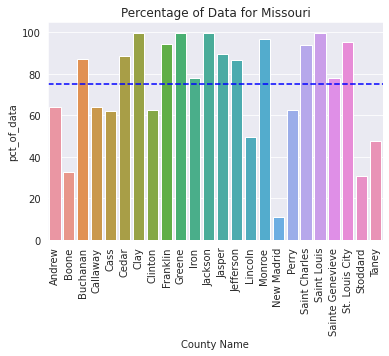

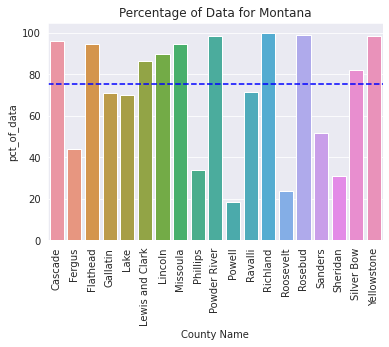

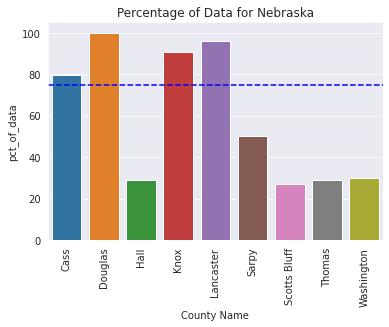

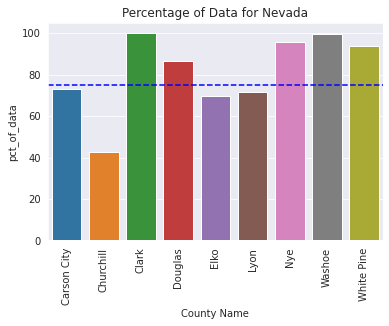

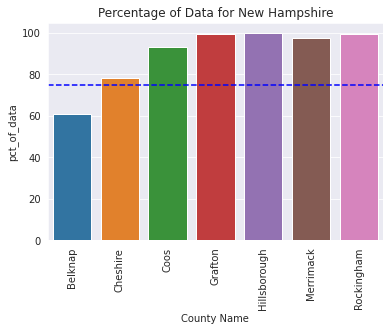

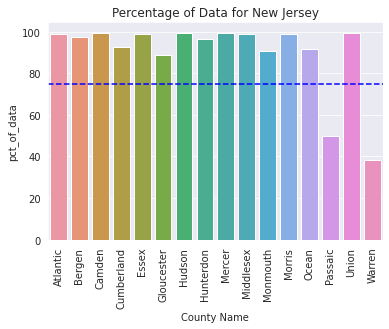

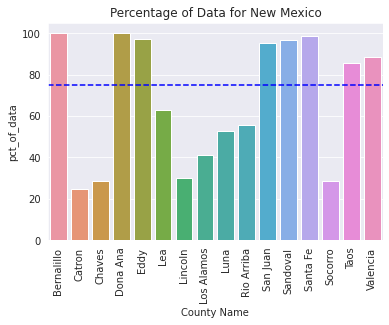

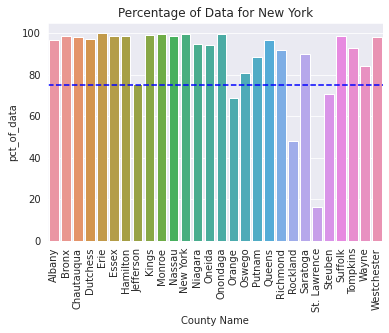

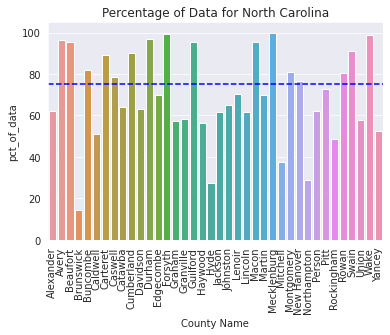

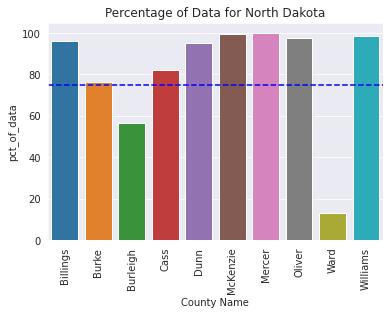

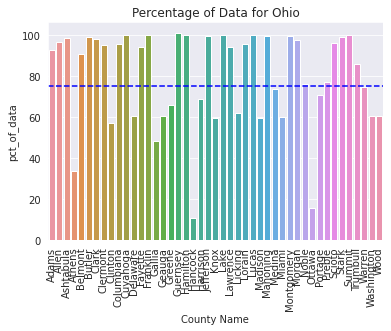

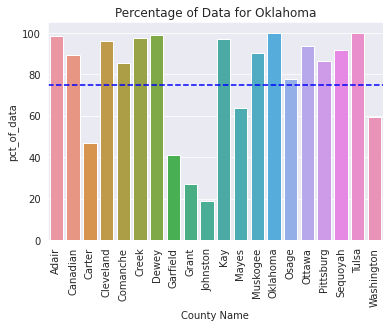

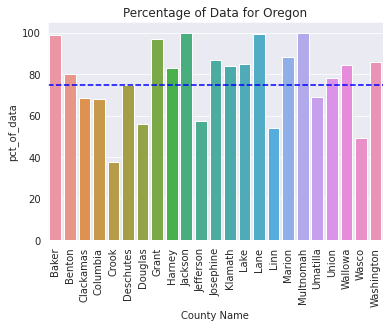

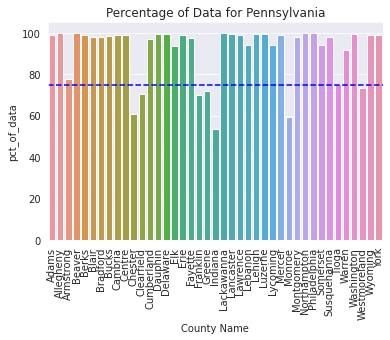

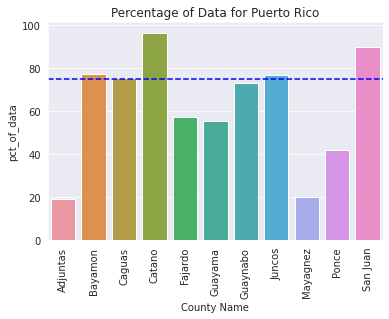

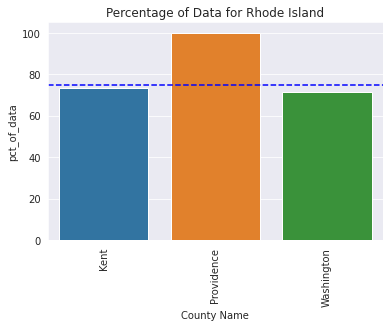

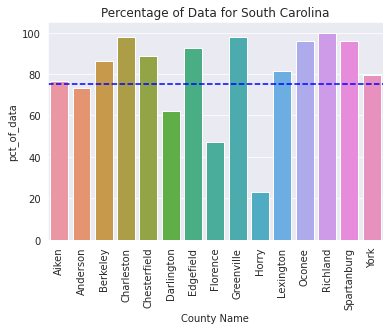

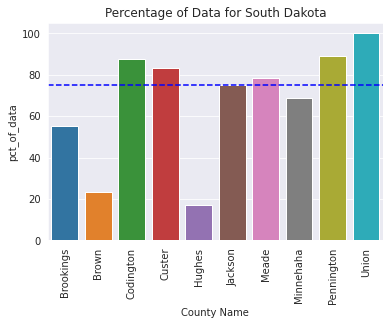

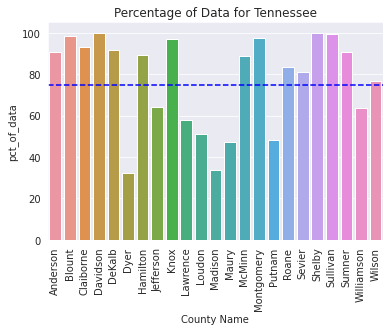

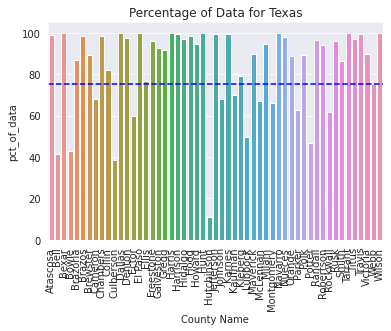

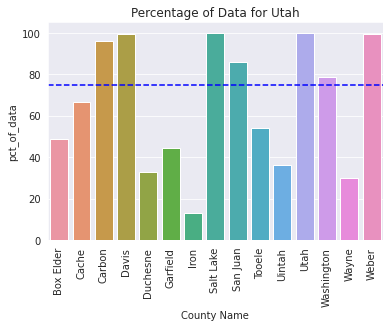

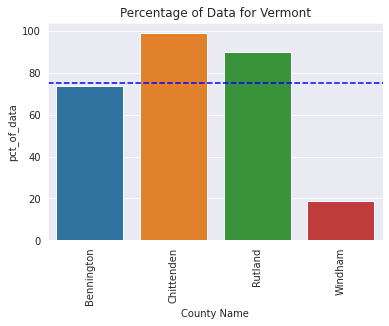

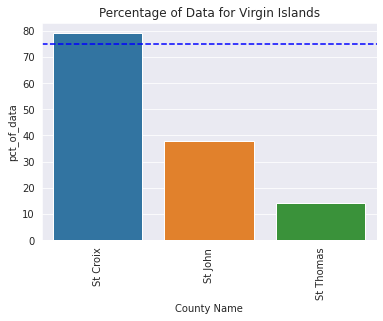

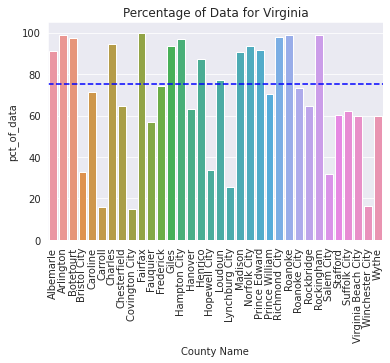

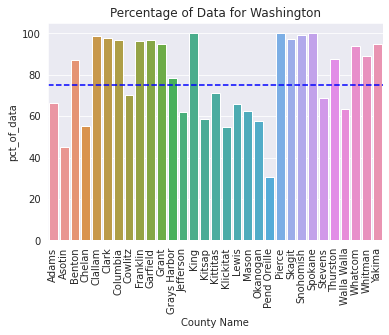

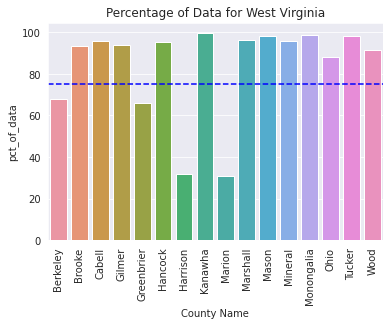

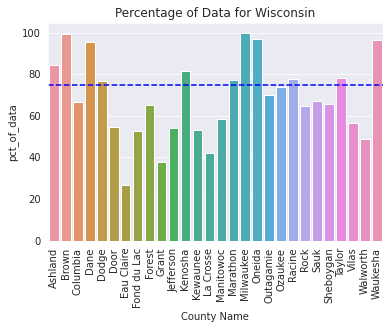

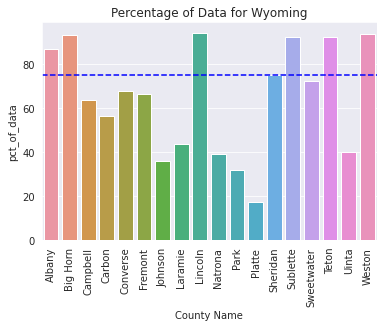

In [ ]:
# create bar plot for each state
for state in aqi_counts_df['State Name'].unique():
    # filter data for the current state
    state_data = aqi_counts_df[aqi_counts_df['State Name'] == state]
    # create bar plot
    sns.barplot(x='County Name', y='pct_of_data', data=state_data)
    # set plot title
    plt.xticks(rotation = 90)
    plt.axhline(y=75, color='Blue', linestyle = '--')
    plt.title(f'Percentage of Data for {state}')
    # display plot
    plt.show()

---

## Selecting one county for EDA and Cleaning: NJ - Bergen County

**Test the model using one county in NJ**

In [ ]:
nj_bergen_df = aqi[(aqi["State Name"] == "New Jersey") & (aqi["County Name"] == "Bergen")]

In [ ]:
nj_bergen_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14573 entries, 120981 to 9997920
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   State Name          14573 non-null  object        
 1   Date                14573 non-null  datetime64[ns]
 2   AQI                 14573 non-null  int64         
 3   Category            14573 non-null  object        
 4   Defining Parameter  14573 non-null  object        
 5   Latitude            14573 non-null  float64       
 6   Longitude           14573 non-null  float64       
 7   County Name         14573 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 1.0+ MB


In [ ]:
nj_bergen_df.head()

State Name       Date  AQI  Category Defining Parameter  Latitude  \
120981  New Jersey 1980-01-01   66  Moderate                 CO  40.85355   
120982  New Jersey 1980-01-02   34      Good                SO2  40.85355   
120983  New Jersey 1980-01-03   34      Good                SO2  40.85355   
120984  New Jersey 1980-01-04   37      Good                SO2  40.85355   
120985  New Jersey 1980-01-05   50      Good                SO2  40.85355   

        Longitude County Name  
120981  -73.96618      Bergen  
120982  -73.96618      Bergen  
120983  -73.96618      Bergen  
120984  -73.96618      Bergen  
120985  -73.96618      Bergen

In [ ]:
#remove 0 values in AQI (assume as not recorded):
nj_bergen_df = nj_bergen_df[nj_bergen_df['AQI'] != 0]

In [ ]:
#convert Date 
nj_bergen_df['Date'] = pd.to_datetime(nj_bergen_df['Date'])

#set Date as Index
nj_bergen_df = nj_bergen_df.set_index('Date')

nj_bergen_df.head()

State Name  AQI  Category Defining Parameter  Latitude  Longitude  \
Date                                                                            
1980-01-01  New Jersey   66  Moderate                 CO  40.85355  -73.96618   
1980-01-02  New Jersey   34      Good                SO2  40.85355  -73.96618   
1980-01-03  New Jersey   34      Good                SO2  40.85355  -73.96618   
1980-01-04  New Jersey   37      Good                SO2  40.85355  -73.96618   
1980-01-05  New Jersey   50      Good                SO2  40.85355  -73.96618   

           County Name  
Date                    
1980-01-01      Bergen  
1980-01-02      Bergen  
1980-01-03      Bergen  
1980-01-04      Bergen  
1980-01-05      Bergen

In [ ]:
# add lines for each column
fig = px.line(nj_bergen_df, x=nj_bergen_df.index, y=nj_bergen_df.AQI)

# axis labels and title
fig.update_layout(
    yaxis_title="Air Quality Index", 
    legend_title="", 
    title="Daily air quality index from 2017 to 2020 for New Jersey - Bergen County")

# activate slider
fig.update_xaxes(rangeslider_visible=True)
plt.savefig('/content/drive/MyDrive/2022 - BrainStation/AirQuality_Capstone/plots/DailyAQI_prediction.png')

fig.show()

<Figure size 432x288 with 0 Axes>

In [ ]:
#slicing to see why difference in AQI from Moderate to Unhealthy to Good in mid-year 1998
nj_bergen_df.loc['1998-05-15':'1998-05-23']

State Name  AQI                        Category  \
Date                                                          
1998-05-15  New Jersey  100                        Moderate   
1998-05-16  New Jersey   98                        Moderate   
1998-05-17  New Jersey   73                        Moderate   
1998-05-18  New Jersey   72                        Moderate   
1998-05-19  New Jersey  143  Unhealthy for Sensitive Groups   
1998-05-20  New Jersey   20                            Good   
1998-05-21  New Jersey   20                            Good   
1998-05-22  New Jersey    3                            Good   
1998-05-23  New Jersey    5                            Good   

           Defining Parameter  Latitude  Longitude County Name  
Date                                                            
1998-05-15                NO2  40.85355  -73.96618      Bergen  
1998-05-16                NO2  40.85355  -73.96618      Bergen  
1998-05-17                NO2  40.85355  -73.96618      Bergen  
1998-05-18                SO2  40.85355  -73.96618      Bergen  
1998-05-19              Ozone  40.85355  -73.96618      Bergen  
1998-05-20                SO2  40.85355  -73.96618      Bergen  
1998-05-21                SO2  40.85355  -73.96618      Bergen  
1998-05-22                 CO  40.85355  -73.96618      Bergen  
1998-05-23                 CO  40.85355  -73.96618      Bergen

In [ ]:
first_day = nj_bergen_df.index.min()
Last_day = nj_bergen_df.index.max()

print(first_day)
print(Last_day)

1980-01-01 00:00:00
2020-12-31 00:00:00


In [ ]:
Last_day - first_day

Timedelta('14975 days 00:00:00')

In [ ]:
full_range = pd.date_range(start=first_day, end=Last_day, freq="D")

full_range.difference(nj_bergen_df.index)

DatetimeIndex(['1980-02-03', '1980-02-04', '1980-02-05', '1980-02-08',
               '1980-02-09', '1980-02-10', '1980-02-11', '1980-02-15',
               '1980-02-16', '1980-02-17',
               ...
               '2014-03-02', '2014-03-04', '2014-03-05', '2014-03-07',
               '2014-03-08', '2014-03-10', '2014-03-11', '2020-08-05',
               '2020-08-06', '2020-12-25'],
              dtype='datetime64[ns]', length=404, freq=None)

There are 403 days over 20 years that are missing from the `nj_bergen_df` dataframe. We will add these dates to the index and see if we hav emissing column values.

In [ ]:
nj_bergen_df = nj_bergen_df.sort_index()

In [ ]:
nj_bergen = nj_bergen_df.reindex(full_range)

In [ ]:
nj_bergen.isna().mean()

State Name            0.026976
AQI                   0.026976
Category              0.026976
Defining Parameter    0.026976
Latitude              0.026976
Longitude             0.026976
County Name           0.026976
dtype: float64

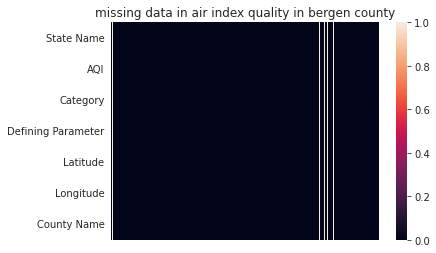

In [ ]:
sns.heatmap(nj_bergen.isna().T,xticklabels = [])
plt.title("missing data in air index quality in bergen county")
plt.show()

In [ ]:
#confirm number of missing rows
nj_bergen[nj_bergen.isna().any(axis=1)]

State Name  AQI Category Defining Parameter  Latitude  Longitude  \
1980-02-03        NaN  NaN      NaN                NaN       NaN        NaN   
1980-02-04        NaN  NaN      NaN                NaN       NaN        NaN   
1980-02-05        NaN  NaN      NaN                NaN       NaN        NaN   
1980-02-08        NaN  NaN      NaN                NaN       NaN        NaN   
1980-02-09        NaN  NaN      NaN                NaN       NaN        NaN   
...               ...  ...      ...                ...       ...        ...   
2014-03-10        NaN  NaN      NaN                NaN       NaN        NaN   
2014-03-11        NaN  NaN      NaN                NaN       NaN        NaN   
2020-08-05        NaN  NaN      NaN                NaN       NaN        NaN   
2020-08-06        NaN  NaN      NaN                NaN       NaN        NaN   
2020-12-25        NaN  NaN      NaN                NaN       NaN        NaN   

           County Name  
1980-02-03         NaN  
1980-02-04         NaN  
1980-02-05         NaN  
1980-02-08         NaN  
1980-02-09         NaN  
...                ...  
2014-03-10         NaN  
2014-03-11         NaN  
2020-08-05         NaN  
2020-08-06         NaN  
2020-12-25         NaN  

[404 rows x 7 columns]

This confirms that these 404 values are missing from the exactly the same rows in all 7 columns.

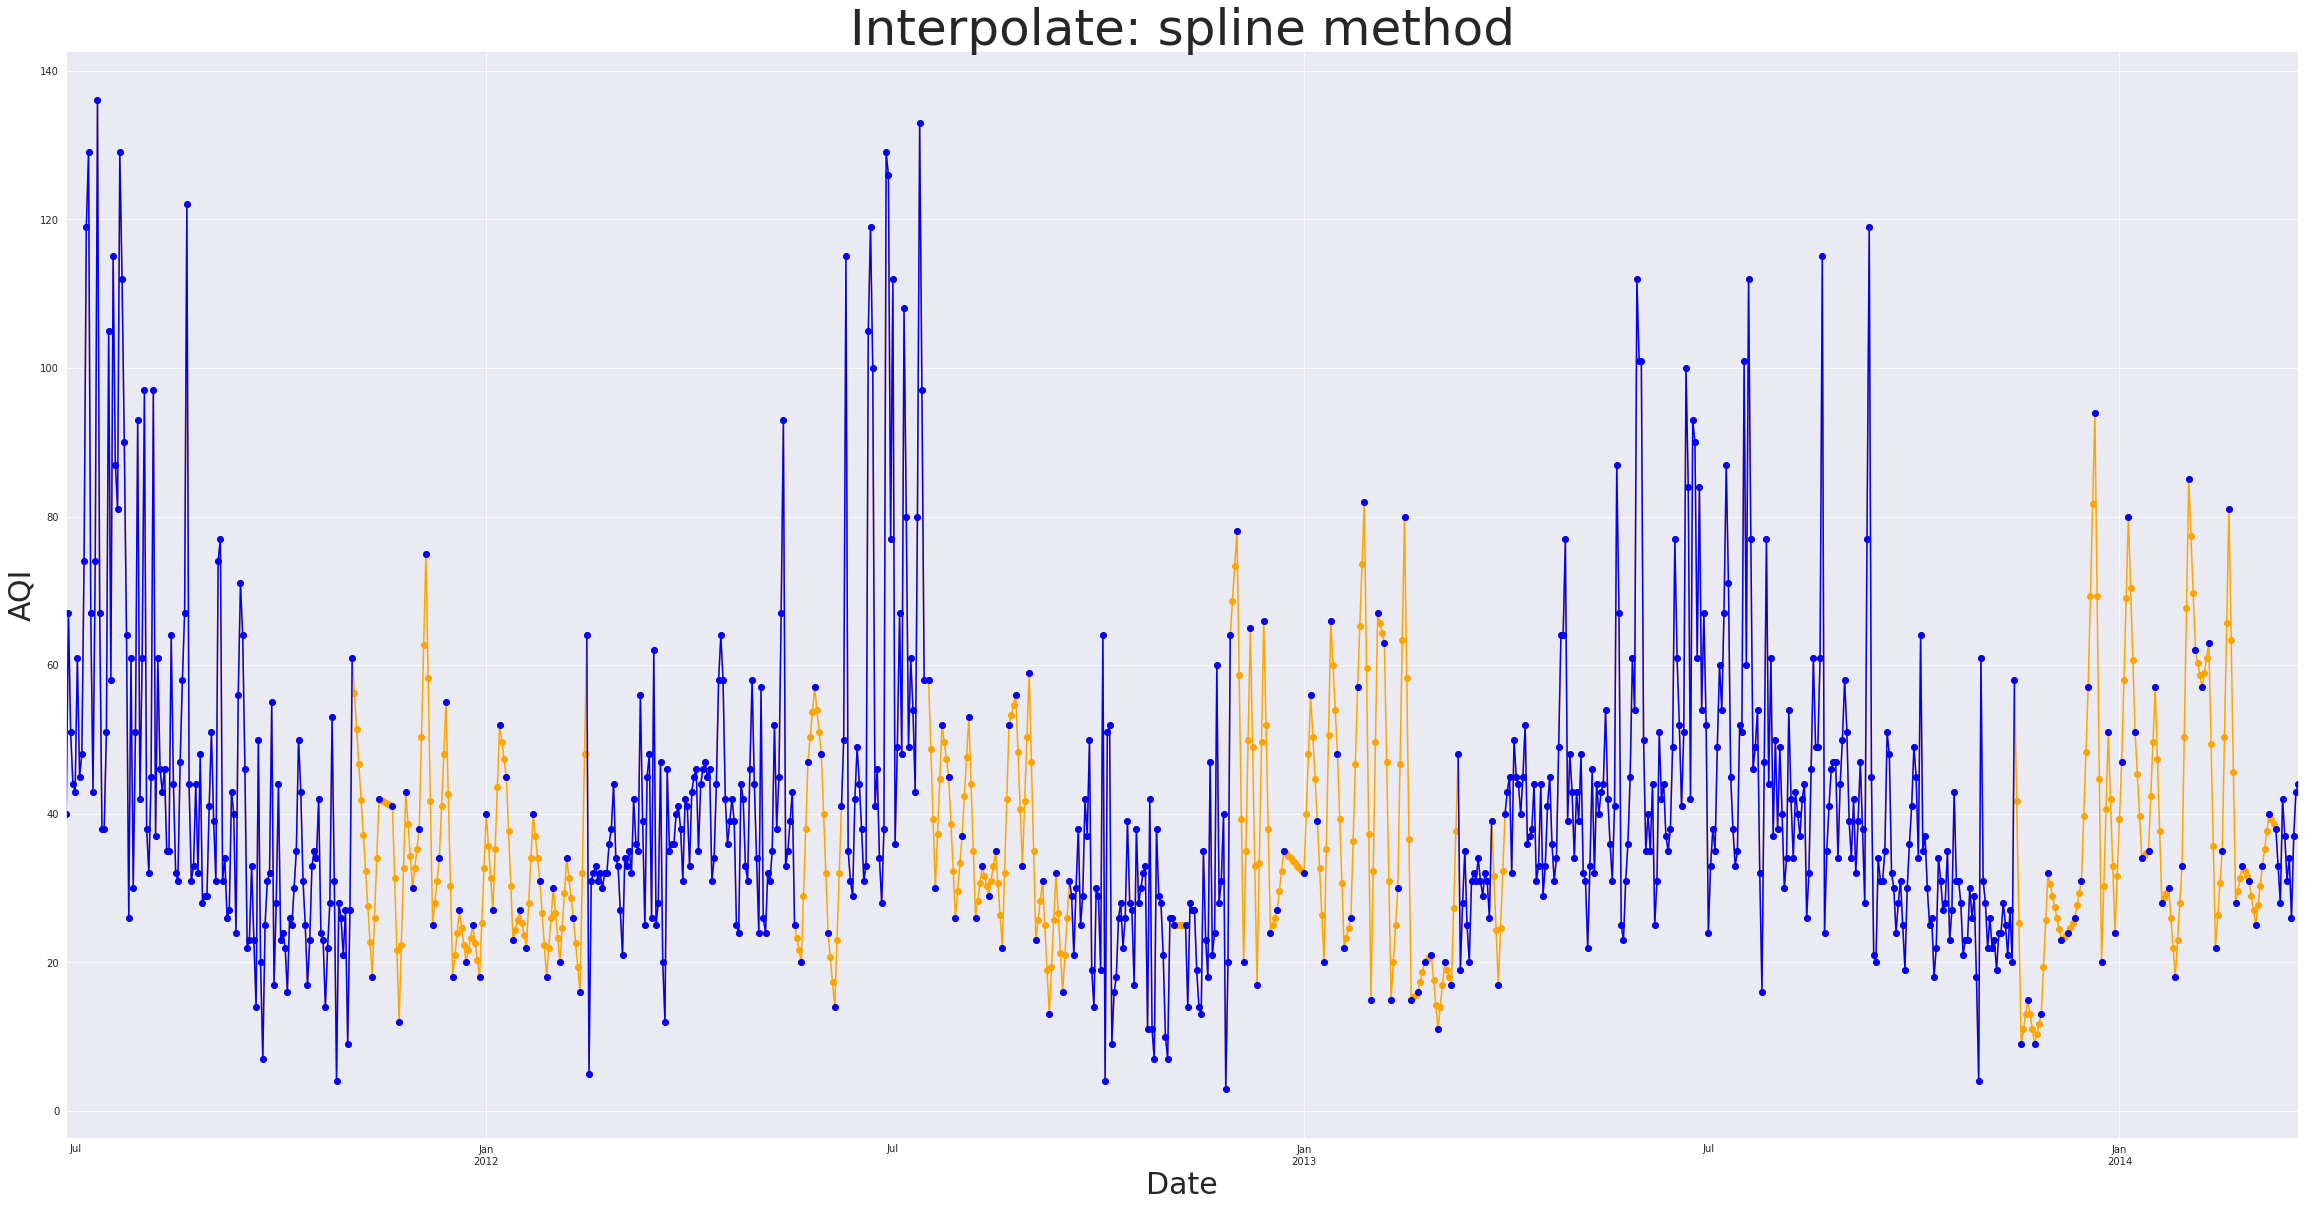

In [ ]:
#spline: Estimates values that minimize overall curvature, thus obtaining a smooth 
#surface passing through the input points.
nj_bergen['AQI'][11500:12500].interpolate(method = 'linear',option = "spline").plot(marker = 'o',color = 'orange')
nj_bergen['AQI'][11500:12500].plot(figsize = (40,20),marker = 'o',color = 'blue')
plt.title("Interpolate: spline method", size =50)
plt.ylabel('AQI', fontsize = 30)
plt.xlabel('Date', fontsize = 30)
plt.savefig('/content/drive/MyDrive/2022 - BrainStation/AirQuality_Capstone/plots/interpolation.png')
plt.show()

## Fill missing values

In [ ]:
missing_columns = ['State Name','Latitude','Longitude','County Name']

In [ ]:
#forward fill the missing columns
for col in missing_columns:
    nj_bergen[col].fillna(method = 'ffill', inplace = True)

In [ ]:
#interpolate using spline
nj_bergen['AQI'] = nj_bergen['AQI'].interpolate(method = 'linear',option = "spline")

In [ ]:
#recall the category dataframe
aqi_category

Category  Minimum_AQI  Maximum_AQI
0                            Good            0           50
2                        Moderate           51          100
4  Unhealthy for Sensitive Groups          101          150
3                       Unhealthy          151          200
5                  Very Unhealthy          201          300
1                       Hazardous          301        20646

In [ ]:
#define category based on interpolation
# aqi_ranges = [0, 51, 101, 151, 201, 301, np.inf]
# aqi_categories = ['Good', 'Moderate','Unhealthy for Sensitive Groups','Unhealthy','Very Unhealthy','Hazardous']
# aqi_dict = dict(zip(pd.IntervalIndex.from_breaks(aqi_ranges[:-1]), aqi_categories))

aqi_dict = {
    pd.Interval(left=-np.inf, right=50.00): 'Good',
    pd.Interval(left=50.01, right=100): 'Moderate',
    pd.Interval(left=100.01, right=150): 'Unhealthy for Sensitive Groups',
    pd.Interval(left=150.01, right=200): 'Unhealthy',
    pd.Interval(left=200.01, right=300): 'Very Unhealthy',
    pd.Interval(left=300.01, right=np.inf): 'Hazardous'
}

#fill only NaN values
nj_bergen['Category'] = nj_bergen['Category'].combine_first(nj_bergen['AQI'].map(aqi_dict))

#fill only NaN values for 'Defining Parameter':
nj_bergen['Defining Parameter'] = nj_bergen['Defining Parameter'].fillna('EST')

In [ ]:
#Understand the category grouping for this dataset
aqi_category2 = nj_bergen.groupby(['Category']).agg(
             count = ('AQI','count'),
             Minimum_AQI = ('AQI','min'),
             Maximum_AQI = ('AQI','max')
)

#reset index
aqi_category2 = aqi_category2.reset_index().sort_values('Minimum_AQI')

#view the data
aqi_category2

Category  count  Minimum_AQI  Maximum_AQI
0                            Good   9047     1.000000         50.0
1                        Moderate   4961    50.333333        100.0
3  Unhealthy for Sensitive Groups    709   101.000000        150.0
2                       Unhealthy    198   151.000000        200.0
4                  Very Unhealthy     61   201.000000        259.0

In [ ]:
#Understand the category grouping for this dataset
aqi_param2 = nj_bergen.groupby(['Defining Parameter']).agg(
             count = ('AQI','count')
)

#reset index
aqi_param2 = aqi_param2.sort_values('count', ascending=False)

#view the data
aqi_param2

count
Defining Parameter       
NO2                  5122
Ozone                4018
PM2.5                2835
SO2                  1490
CO                    980
EST                   404
PM10                  127

In [ ]:
total=nj_bergen['AQI'].count()

print(403/total*100)

2.6909722222222223


In [ ]:
nj_bergen.astype('object').describe().transpose()

count unique         top     freq
State Name            14976      1  New Jersey    14976
AQI                 14976.0  359.0        42.0    447.0
Category              14976      5        Good     9047
Defining Parameter    14976      7         NO2     5122
Latitude            14976.0    1.0    40.85355  14976.0
Longitude           14976.0    1.0   -73.96618  14976.0
County Name           14976      1      Bergen    14976

In [ ]:
#confirm no more missing values
nj_bergen[nj_bergen.isna().any(axis=1)]

Empty DataFrame
Columns: [State Name, AQI, Category, Defining Parameter, Latitude, Longitude, County Name]
Index: []

## Explore time of year - Observation using Monthly

In [ ]:
# the "MS" option specifies Monthly frequency by Start day

nj_bergen_monthly_mean = nj_bergen.resample("MS").mean()

nj_bergen_monthly_mean.head()

AQI  Latitude  Longitude
1980-01-01  54.483871  40.85355  -73.96618
1980-02-01  46.396552  40.85355  -73.96618
1980-03-01  46.290323  40.85355  -73.96618
1980-04-01  58.833333  40.85355  -73.96618
1980-05-01  74.387097  40.85355  -73.96618

In [ ]:
#view monthly average
fig = px.line(nj_bergen_monthly_mean, x=nj_bergen_monthly_mean.index, y="AQI")

fig.update_layout(
    yaxis_title="Air Quality Index by Monthly Average", 
    xaxis_title="Year",
    legend_title="", 
    title="Air Quality Index from 1980 to 2020"
)
fig.show()

In [ ]:
nj_bergen_monthly_mean = nj_bergen_monthly_mean.loc[nj_bergen_monthly_mean.index,['AQI']]

nj_bergen_monthly_mean.tail()

AQI
2020-08-01  46.387097
2020-09-01  37.600000
2020-10-01  35.225806
2020-11-01  37.533333
2020-12-01  40.919355

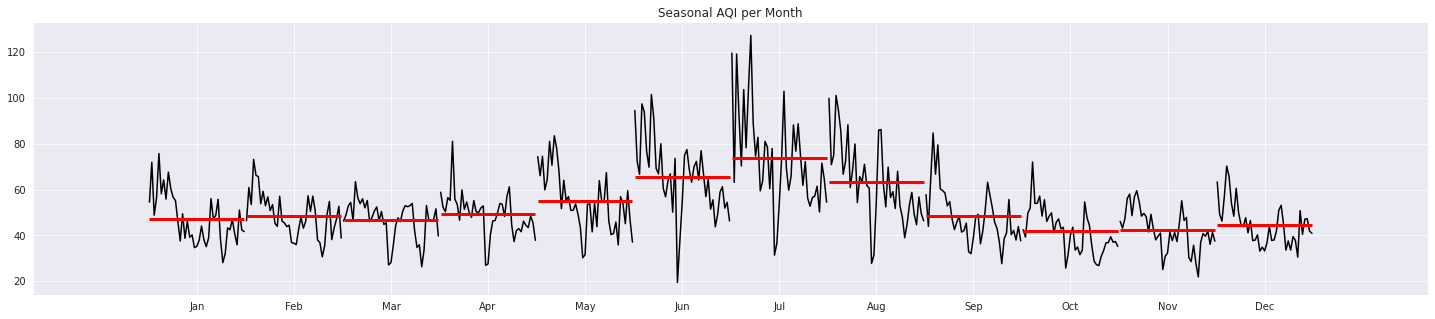

In [ ]:
from statsmodels.graphics.tsaplots import month_plot

plt.figure(figsize=(25, 5))

# create the seasonal plot
month_plot(nj_bergen_monthly_mean["AQI"], ax=plt.gca())

plt.title("Seasonal AQI per Month")
sns.despine()
plt.show()

In [ ]:
# decompose the time series
decomposition = tsa.seasonal_decompose(nj_bergen_monthly_mean, model='additive')

In [ ]:
type(decomposition)

statsmodels.tsa.seasonal.DecomposeResult

In [ ]:
# add the decomposition data

nj_bergen_monthly_mean["Trend"] = decomposition.trend
nj_bergen_monthly_mean["Seasonal"] = decomposition.seasonal
nj_bergen_monthly_mean["Residual"] = decomposition.resid

nj_bergen_monthly_mean.head(20)

AQI      Trend   Seasonal   Residual
1980-01-01   54.483871        NaN  -5.110012        NaN
1980-02-01   46.396552        NaN  -3.496557        NaN
1980-03-01   46.290323        NaN  -5.160006        NaN
1980-04-01   58.833333        NaN  -2.922061        NaN
1980-05-01   74.387097        NaN   2.540960        NaN
1980-06-01   94.466667        NaN  13.001387        NaN
1980-07-01  119.483871  67.717723  21.742626  30.023521
1980-08-01   99.806452  69.047543  11.065867  19.693042
1980-09-01   57.766667  69.760426  -3.658177  -8.335582
1980-10-01   42.532258  69.594297 -10.418185 -16.643854
1980-11-01   46.133333  68.971179 -10.116853 -12.720992
1980-12-01   63.322581  67.702227  -7.468988   3.089342
1981-01-01   71.903226  64.434620  -5.110012  12.578618
1981-02-01   60.892857  60.882200  -3.496557   3.507214
1981-03-01   48.903226  59.101555  -5.160006  -5.038323
1981-04-01   52.233333  58.390131  -2.922061  -3.234737
1981-05-01   66.032258  58.132873   2.540960   5.358425
1981-06-01   72.366667  57.424674  13.001387   1.940606
1981-07-01   63.161290  55.874942  21.742626 -14.456279
1981-08-01   70.870968  54.603053  11.065867   5.202048

In [ ]:
cols = ["Trend", "Seasonal", "Residual"]

fig = make_subplots(rows=3, cols=1, subplot_titles=cols)

for i, col in enumerate(cols):
    fig.add_trace(
        go.Scatter(x=nj_bergen_monthly_mean.index, y=nj_bergen_monthly_mean[col]),
        row=i+1,
        col=1
    )

fig.update_layout(height=800, width=1000, showlegend=False)
fig.show()

Here are a few observations from the above:
- There was a steady decline of air quality (note that lower air quality values are considered as good) from 1985 to 2000. However, there was a rise in air quality that now has an increase and decrease. 
- It appears that the month of July has the highest air quality (which means it is not good) and could possibly attributed to weather during summer. 
- For the residuals, there is a slight seasonality, with that big reduction in 1998 due to change in parameter (as seen in initial EDA). 
- Perhaps there's a better way to decompose this, re-read this article again:
    https://towardsdatascience.com/different-types-of-time-series-decomposition-396c09f92693
    
---

In [ ]:
# Create a bar chart with hue based on a categorical variable
fig = px.scatter(nj_bergen, x=nj_bergen.index, y='AQI', color='Defining Parameter')

# Add labels to the chart
fig.update_layout(title='Value by Category', xaxis_title='Category', yaxis_title='Value')
fig.update_xaxes(rangeslider_visible=True)

# Show the chart
fig.show()

# Test for Stationarity and understanding ARIMA Parameters

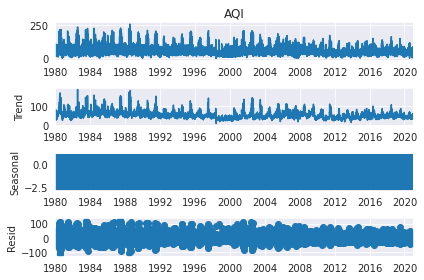

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_data = seasonal_decompose(nj_bergen['AQI'], model="additive")
decompose_data.plot();

In [ ]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(nj_bergen['AQI'])

# Convert the result to a dataframe
adf_df = pd.DataFrame({
    'ADF Statistic': adf_result[0],
    'p-value': adf_result[1],
    'Used Lag': adf_result[2],
    'Number of Observations': adf_result[3],
    'Critical Values': adf_result[4],
    'IC Best': adf_result[5]
})

# Print the dataframe
adf_df

ADF Statistic       p-value  Used Lag  Number of Observations  \
1%       -9.170371  2.397414e-15        41                   14934   
10%      -9.170371  2.397414e-15        41                   14934   
5%       -9.170371  2.397414e-15        41                   14934   

     Critical Values        IC Best  
1%         -3.430788  136477.869811  
10%        -2.566873  136477.869811  
5%         -2.861734  136477.869811

In [ ]:
def test_stationarity(timeseries):
    
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    
    critical_value = dftest[4]['5%']
    test_statistic = dftest[0]
    alpha = 1e-3
    pvalue = dftest[1]
    if pvalue < alpha and test_statistic < critical_value:  # null hypothesis: x is non stationary
        print("X is stationary")
        return True
    else:
        print("X is not stationary")
        return False

In [ ]:
test_stationarity(nj_bergen['AQI'])

X is stationary


True

# SARIMA - Hyperparameter Optimization

Configuring a SARIMA requires selecting hyperparameters for both the trend and seasonal elements of the series.

There are three trend elements that require configuration.

They are the same as the ARIMA model; specifically:

- p: Trend autoregression order.
- d: Trend difference order.
- q: Trend moving average order.

There are four seasonal elements that are not part of ARIMA that must be configured; they are:

- P: Seasonal autoregressive order.
- D: Seasonal difference order.
- Q: Seasonal moving average order.
- m: The number of time steps for a single seasonal period.



In [ ]:
train = nj_bergen.loc[nj_bergen.index <= "2019-07-01", "AQI"]
val = nj_bergen.loc[nj_bergen.index > "2019-07-01", "AQI"]

In [ ]:
full_index = pd.concat([train, val]).index
base_line = np.full(full_index.shape, np.mean(nj_bergen['AQI']))
predictions_mean = pd.Series(data=base_line, index=full_index)

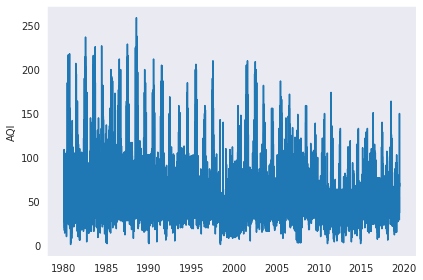

In [ ]:
plt.plot(train)
plt.ylabel('AQI')
plt.grid()
plt.tight_layout()
plt.savefig('/content/drive/MyDrive/2022 - BrainStation/AirQuality_Capstone/plots/AQI_bergen.png')
plt.show()

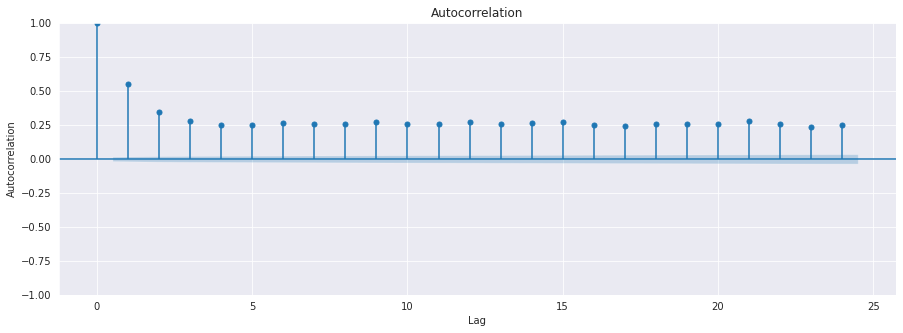

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(15, 5))
plot_acf(nj_bergen["AQI"].dropna(), lags=24, ax=plt.gca())
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()

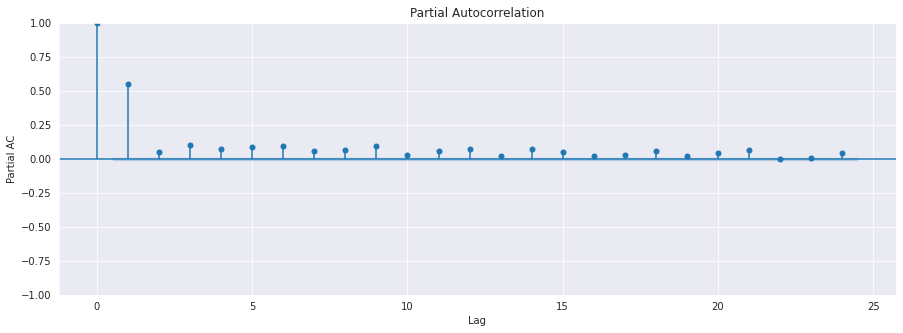

In [ ]:
# put the pacf plot on the current axis
plt.figure(figsize=(15, 5))
plot_pacf(nj_bergen['AQI'].dropna(), lags=24, ax=plt.gca(), method='ywm')
plt.xlabel('Lag')
plt.ylabel('Partial AC')
plt.show()

d = 1
p = 4
q = 3

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
d = 1
p = 4
q = 3
model = SARIMAX(train, order=(4,1,3),seasonal_order=(0,0,0,0), trend = 'c')
model_fit = model.fit(max_iter=100)
fcast = model_fit.get_prediction(start=1, end=len(train))
ts_p = fcast.predicted_mean
ts_ci = fcast.conf_int()

/usr/local/lib/python3.9/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [ ]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    AQI   No. Observations:                14427
Model:               SARIMAX(4, 1, 3)   Log Likelihood              -66091.497
Date:                Mon, 27 Mar 2023   AIC                         132200.995
Time:                        00:27:11   BIC                         132269.186
Sample:                    01-01-1980   HQIC                        132223.663
                         - 07-01-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0441      0.035     -1.253      0.210      -0.113       0.025
ar.L1         -0.5544      0.010    -57.945      0.000      -0.573      -0.536
ar.L2         -0.6088      0.009    -68.297      0.000      -0.626      -0.591
ar.L3          0.3632      0.007     50.515      0.000       0.349       0.377
ar.L4         -0.0644      0.006    -10.346      0.000      -0.077      -0.052
ma.L1          0.0369      0.008      4.523      0.000       0.021       0.053
ma.L2          0.0225      0.008      2.876      0.004       0.007       0.038
ma.L3         -0.9164      0.007   -124.832      0.000      -0.931      -0.902
sigma2       556.8608      4.172    133.465      0.000     548.683     565.038
===================================================================================
Ljung-Box (L1) (Q):                   3.19   Jarque-Bera (JB):             14069.32
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               0.40   Skew:                             1.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
predictions = model_fit.predict(start=0, end=len(train)+len(val)-1)

In [ ]:
base_line = np.full(full_index.shape, np.mean(train))
predictions_mean = pd.Series(data=base_line, index=full_index)

In [ ]:
def mean_absolute_percentage_error(true_values, predicted_values):
    """
    Calculate the mean absolute percentage error. 
    Find the prediction error and devide by the true value, then average.
    """
    
    error = true_values - predicted_values
    absolute_percentage_error = np.abs(error/true_values)
    mape = absolute_percentage_error.mean() * 100
    
    return mape

In [ ]:
train_mape = mean_absolute_percentage_error(train, predictions[train.index])
mean_mape = mean_absolute_percentage_error(train, predictions_mean[train.index])
test_mape = mean_absolute_percentage_error(val, predictions[val.index])


print(f"Train MAPE on the difference: {round(train_mape, 2)}%")
print(f"Mean MAPE on the difference: {round(mean_mape, 2)}%")
print(f"Test MAPE on the difference: {round(test_mape, 2)}%")

Train MAPE on the difference: 37.83%
Mean MAPE on the difference: 51.92%
Test MAPE on the difference: 47.58%


In [ ]:
from sklearn.metrics import mean_squared_error

# compare the predicted values to the actual values
error = mean_squared_error(train, predictions[train.index], squared=False)
mean_error = mean_squared_error(train, predictions_mean[train.index], squared=False)
test_error = mean_squared_error(val, predictions[val.index], squared=False)


# print the RMSE

print(f"Train MSE on the difference: {round(error, 2)}%")
print(f"Mean MSE on the difference: {round(mean_error, 2)}%")
print(f"Test MSE on the difference: {round(test_error, 2)}%")

Train MSE on the difference: 23.63%
Mean MSE on the difference: 29.56%
Test MSE on the difference: 17.15%


In [ ]:
from scipy import stats
stats.pearsonr(ts_p[1:], train[1:])

PearsonRResult(statistic=0.912606706453814, pvalue=0.0)

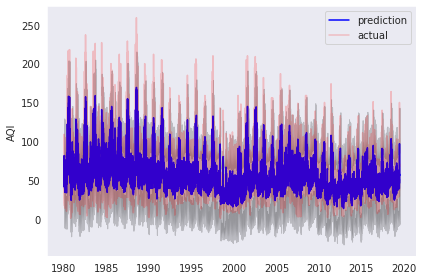

In [ ]:
plt.plot(ts_p,label='prediction',color='blue')
plt.plot(train,color='red',label='actual', alpha=0.2)
plt.fill_between(ts_ci.index[1:],
                ts_ci.iloc[1:, 0],
                ts_ci.iloc[1:, 1], color='k', alpha=.2)
plt.ylabel('AQI')
plt.legend()
plt.tight_layout()
plt.grid()
plt.savefig('/content/drive/MyDrive/2022 - BrainStation/AirQuality_Capstone/plots/trend_prediction.png')
plt.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=val.index, y=val, mode='lines', name="Test"))
fig.add_trace(go.Scatter(x=train.index, y=train, mode='lines', name="Train"))
fig.add_trace(go.Scatter(x=predictions.index, y=predictions, mode='lines', name="ARIMA Prediction"))
fig.add_trace(go.Scatter(x=predictions_mean.index, y=predictions_mean, name="Mean Predictions"))

fig.update_xaxes(rangeslider_visible=True)
fig.update_layout(
    yaxis_title="AQI", 
    xaxis_title="Date",
    title="AQI Train vs Prediction"
)
plt.savefig('/content/drive/MyDrive/2022 - BrainStation/AirQuality_Capstone/plots/AQI_train vs predict.png')
fig.show()

<Figure size 432x288 with 0 Axes>

## SARIMAX - Cross Validation

Now suppose your validation data is a year, but you only care about a 14 day forecast. instead of predicting forward from the beginning of the validation set all the way to the end, you can make 14 days worth of predictions at the beginning of the validation data. then move forward 14 days, and predict another 14 days into the future, you can then average your errors for 1 day forward, 2 day forward.

Performing a 14-day forecast Cross Validation

In [ ]:
#new split
train = nj_bergen.loc[nj_bergen.index < "2020-01-01", "AQI"]
test = nj_bergen.loc[nj_bergen.index >= "2020-01-01", "AQI"]

In [ ]:
!pip3 install arch yfinance pmdarima --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 908.0/908.0 KB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 60.1 MB/s eta 0:00:00


In [ ]:
from pmdarima.arima import auto_arima

In [ ]:
model_auto = auto_arima(train)

In [ ]:
optimal_order = model_auto.order

In [ ]:
from statsmodels.tsa.arima.params import SARIMAXParams
from sklearn.model_selection import TimeSeriesSplit

# Define the number of folds for cross-validation
step_size = 7
n_folds = int(round((len(test)-step_size) / step_size +1,0)) # 7 days

# Initialize an empty list to store the MSE scores
mse_scores = []
mape_scores = []
baseline_mse = []
baseline_mape = []
train_start = []
train_end = []
test_start = []
test_end = []

# Initialize the TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=n_folds)

# Loop through each split and train the model
for train_index, test_index in tscv.split(test):
    # Get the training and testing data for this split
    train_data = pd.concat([train, test.iloc[train_index]])
    test_data = test.iloc[test_index]

    # Initialize the ARIMA model
    new_model = SARIMAX(train_data, order=optimal_order)
    fitted_model = new_model.fit()

    # Make predictions for the test set using the fitted model
    predictions = fitted_model.predict(start=test_data.index[0], end=test_data.index[-1])

    #calculate baseline
    base_line = np.full(test_data.shape, np.mean(train_data))
    baseline_mean = pd.Series(data=base_line, index=test_data.index)
    
    # Calculate the MSE score for this fold
    baseline = mean_squared_error(test_data, baseline_mean[test_data.index])
    mse = mean_squared_error(test_data, predictions[test_data.index])
    baseline_mape_calc = mean_absolute_percentage_error(test_data, baseline_mean[test_data.index])
    mape = mean_absolute_percentage_error(test_data, predictions[test_data.index])
    train_s = train_data.index[0]
    train_e = train_data.index[-1]
    test_s = test_data.index[0]
    test_e = test_data.index[-1]


    baseline_mse.append(baseline)
    mse_scores.append(mse)
    baseline_mape.append(baseline_mape_calc)
    mape_scores.append(mape)
    train_start.append(train_s)
    train_end.append(train_e)
    test_start.append(test_s)
    test_end.append(test_e)

    data = {'baseline_mse': baseline_mse, 
        'mse_scores': mse_scores, 
        'baseline_mape': baseline_mape, 
        'mape_scores': mape_scores, 
        'train_start': train_start, 
        'train_end': train_end, 
        'test_start': test_start, 
        'test_end': test_end}

    result_rolling = pd.DataFrame(data)


In [ ]:
result_rolling

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(result_rolling['test_start'], result_rolling['baseline_mape'], c='blue', label='Baseline')
plt.plot(result_rolling['test_start'], result_rolling['mape_scores'], c='red', label='Cross-Validation')
plt.xlabel('Date of Cross Val')
plt.ylabel('MAPE %')
plt.title("Time Series Cross-Validation")
plt.legend()
plt.show()

In [ ]:
# Calculate the average MSE score across all folds
avg_mse = np.mean(mse_scores)

# Calculate the baseline average
avg_mse_baseline = np.mean(baseline_mse)

# Calculate the baseline average
avg_mape_baseline = np.mean(baseline_mape)

# Calculate the baseline average
avg_mape = np.mean(mape_scores)

print(avg_mse)
print(avg_mse_baseline)
print(avg_mape)
print(avg_mape_baseline)

233.92452835967867
361.86432950379645
47.20343603203695
69.92942996939836


In [ ]:
result_rolling

## SARIMAX - Cross Validation: 2015-2020

Now suppose your validation data is a year, but you only care about a 14 day forecast. instead of predicting forward from the beginning of the validation set all the way to the end, you can make 14 days worth of predictions at the beginning of the validation data. then move forward 14 days, and predict another 14 days into the future, you can then average your errors for 1 day forward, 2 day forward.

Performing a 14-day forecast Cross Validation

In [ ]:
# Select rows up to 2015
bergen_2015 = nj_bergen.loc['2015-01-01':]

In [ ]:
#new split
train = bergen_2015.loc[bergen_2015.index < "2020-01-01", "AQI"]
test = bergen_2015.loc[bergen_2015.index >= "2020-01-01", "AQI"]

In [ ]:
model_auto = auto_arima(train)

In [ ]:
model_auto

ARIMA(order=(1, 0, 3), scoring_args={}, suppress_warnings=True)

In [ ]:
optimal_order = model_auto.order

In [ ]:
from statsmodels.tsa.arima.params import SARIMAXParams
from sklearn.model_selection import TimeSeriesSplit

# Define the number of folds for cross-validation
step_size = 7
n_folds = int(round((len(test)-step_size) / step_size +1,0)) # 7 days

# Initialize an empty list to store the MSE scores
mse_scores = []
mape_scores = []
baseline_mse = []
baseline_mape = []
train_start = []
train_end = []
test_start = []
test_end = []

# Initialize the TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=n_folds)

# Loop through each split and train the model
for train_index, test_index in tscv.split(test):
    # Get the training and testing data for this split
    train_data = pd.concat([train, test.iloc[train_index]])
    test_data = test.iloc[test_index]

    # Initialize the ARIMA model
    new_model = SARIMAX(train_data, order=optimal_order)
    fitted_model = new_model.fit()

    # Make predictions for the test set using the fitted model
    predictions = fitted_model.predict(start=test_data.index[0], end=test_data.index[-1])

    #calculate baseline
    base_line = np.full(test_data.shape, np.mean(train_data))
    baseline_mean = pd.Series(data=base_line, index=test_data.index)
    
    # Calculate the MSE score for this fold
    baseline = mean_squared_error(test_data, baseline_mean[test_data.index])
    mse = mean_squared_error(test_data, predictions[test_data.index])
    baseline_mape_calc = mean_absolute_percentage_error(test_data, baseline_mean[test_data.index])
    mape = mean_absolute_percentage_error(test_data, predictions[test_data.index])
    train_s = train_data.index[0]
    train_e = train_data.index[-1]
    test_s = test_data.index[0]
    test_e = test_data.index[-1]


    baseline_mse.append(baseline)
    mse_scores.append(mse)
    baseline_mape.append(baseline_mape_calc)
    mape_scores.append(mape)
    train_start.append(train_s)
    train_end.append(train_e)
    test_start.append(test_s)
    test_end.append(test_e)

    data = {'baseline_mse': baseline_mse, 
        'mse_scores': mse_scores, 
        'baseline_mape': baseline_mape, 
        'mape_scores': mape_scores, 
        'train_start': train_start, 
        'train_end': train_end, 
        'test_start': test_start, 
        'test_end': test_end}

    result_rolling = pd.DataFrame(data)


In [ ]:
result_rolling

baseline_mse   mse_scores  baseline_mape  mape_scores train_start  \
0     541.343651   434.393834     103.578064    86.147250  2015-01-01   
1     104.099978   141.678830      24.286303    21.185302  2015-01-01   
2      43.309498    33.807187      12.579271    11.908850  2015-01-01   
3      78.830206    10.948460      21.881250     8.209099  2015-01-01   
4     166.231293   114.215470      32.530260    17.614628  2015-01-01   
5     201.697177    52.940274      42.408617    19.779827  2015-01-01   
6     277.197401    63.232103      54.508401    22.799324  2015-01-01   
7      69.699887    29.186448      20.148155    11.372479  2015-01-01   
8      37.106713    14.685662      14.199490     7.925157  2015-01-01   
9     103.045532    20.233542      25.469073     8.865651  2015-01-01   
10    120.183672     7.708867      29.528841     6.334333  2015-01-01   
11     35.828654    25.562638      12.957621     9.343488  2015-01-01   
12    163.705988    41.907086      35.697768    18.210278  2015-01-01   
13     17.651363    51.514635       9.463450    14.798535  2015-01-01   
14    112.593165    18.513505      27.734450    10.251537  2015-01-01   
15    399.126148   141.531569      75.323035    42.879590  2015-01-01   
16    140.269332   187.121748      24.238196    18.702139  2015-01-01   
17    303.335930   417.223125      32.455657    30.510488  2015-01-01   
18     97.400133    31.153281      24.808847    12.151349  2015-01-01   
19    320.476507   383.437647      28.230722    24.975861  2015-01-01   
20    155.259317   250.920041      15.265687    21.235593  2015-01-01   
21     76.584689    90.898541      17.718791    17.650826  2015-01-01   
22    806.698670   813.108107      33.544261    33.092707  2015-01-01   
23    191.381477   174.931138      40.666325    36.929653  2015-01-01   
24    892.012816  1027.350987      24.611448    30.910869  2015-01-01   
25    222.021415   356.591151      15.100564    29.314622  2015-01-01   
26    626.884102   548.997598      26.177534    26.221736  2015-01-01   
27    527.492842   622.326786     800.160651   853.821778  2015-01-01   
28   1041.338658   839.270470      25.838460    22.238537  2015-01-01   
29     83.622846   185.627162      22.323836    35.037971  2015-01-01   
30     72.213801    98.829717      16.266666    18.990457  2015-01-01   
31    281.693436   338.767473      53.929048    60.365523  2015-01-01   
32     93.009156    64.166496      23.125170    19.075043  2015-01-01   
33    255.262193   162.413218      49.799235    40.556500  2015-01-01   
34    245.906886    95.952693      47.495228    29.970991  2015-01-01   
35    298.882302   395.192343      33.693771    28.417454  2015-01-01   
36    265.470646   132.923207      52.297425    36.325852  2015-01-01   
37    240.021380    70.557290      47.797414    26.075989  2015-01-01   
38    313.943705   116.177508      64.048022    36.239987  2015-01-01   
39    148.792841    52.308342      32.909390    16.826245  2015-01-01   
40    344.807536   427.319975      40.362672    37.119548  2015-01-01   
41    387.323360   180.375469      74.839815    49.943928  2015-01-01   
42    170.152076   135.719571      35.605900    24.870699  2015-01-01   
43    384.830555   460.036987      56.960630    45.479902  2015-01-01   
44    419.392159   220.127704     267.779553   203.959872  2015-01-01   
45    139.799357   151.041251      30.100657    23.235450  2015-01-01   
46    238.772179    57.996397      48.955558    22.559521  2015-01-01   
47    377.657792   137.865889      94.676403    57.348216  2015-01-01   
48    400.235989   737.803127      30.386868    42.335031  2015-01-01   
49    340.707077   206.947940      64.042556    48.110867  2015-01-01   
50    463.333594   629.590936      32.989848    31.162911  2015-01-01   
51    332.070501   154.468844      78.139242    52.174117  2015-01-01   

    train_end test_start   test_end  
0  2020-02-23 2020-02-24 2020-02-29  
1  2020-02-29 2020-03-01 2020-03-06  
2  2020-03-06 2020-0

In [ ]:
predictions

2020-12-26    36.717996
2020-12-27    40.957204
2020-12-28    41.889194
2020-12-29    41.877868
2020-12-30    41.866546
2020-12-31    41.855226
Freq: D, Name: predicted_mean, dtype: float64

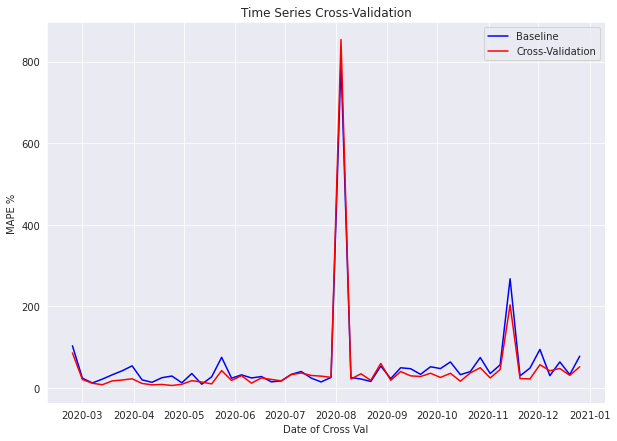

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(result_rolling['test_start'], result_rolling['baseline_mape'], c='blue', label='Baseline')
plt.plot(result_rolling['test_start'], result_rolling['mape_scores'], c='red', label='Cross-Validation')
plt.xlabel('Date of Cross Val')
plt.ylabel('MAPE %')
plt.title("Time Series Cross-Validation")
plt.legend()
plt.show()

In [ ]:
# Calculate the average MSE score across all folds
avg_mse = np.mean(mse_scores)

# Calculate the baseline average
avg_mse_baseline = np.mean(baseline_mse)

# Calculate the baseline average
avg_mape_baseline = np.mean(baseline_mape)

# Calculate the baseline average
avg_mape = np.mean(mape_scores)

print(avg_mse)
print(avg_mse_baseline)
print(avg_mape)
print(avg_mape_baseline)

233.92452835967867
361.86432950379645
47.20343603203695
69.92942996939836


# Conclusion:
Additional features will need to be added to the dataset in order to forecast 7 or 14 days of AQI. To have a complete dataset, see part II - additional data extraction of features (and including a multi-variate time series forecasting, instead of a single time series forecasting). Next steps are as follows:
- Extract County and CSBA (city) information from 2015 to 2022
- Extra all the relevant AQI components and meteorological data from 2015 to 2022
- Combine County data set with relevant AQI data
- Combine CSBA (city) data set with relevant AQI data
- Perform modeling: 
  - single time series forecasting for (one County, one CSBA) across all features
  - multivariate time series forecasting 


ARMA:

SARIMA(X):
https://machinelearningmastery.com/sarima-for-time-series-forecasting-in-python/

PROPHET:

RNN:
https://www.tensorflow.org/tutorials/structured_data/time_series